# Household Power Consumption dataset

***

Info from https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption :


This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).

Notes:

1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

***

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Loading and converting

In [2]:
!head household_power_consumption.txt

In [3]:
!wc -l household_power_consumption.txt

2075260 household_power_consumption.txt


In [4]:
data = pd.read_csv("household_power_consumption.txt", delimiter=";", low_memory=False)

In [5]:
data.shape

(2075259, 9)

In [6]:
data.head()

Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0

Parse the dates

In [7]:
# This is a bit hacky
data['date'] = pd.to_datetime(data['Date']+" "+data['Time'], infer_datetime_format=True, errors='coerce')

data.drop(['Date','Time'], axis=1, inplace=True)
data.set_index('date', inplace=True, drop=True)
data.sort_index(inplace=True)

In [8]:
data.index.isna().sum()

0

We don't have any broken / absent timestamps.

In [9]:
data.head()

Global_active_power Global_reactive_power  Voltage  \
date                                                                     
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
date                                                                 
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.000          1.000   

                     Sub_metering_3  
date                                 
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [10]:
data.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [11]:
for c in data.columns:
    data[c] = pd.to_numeric(data[c], errors='coerce')

In [12]:
data.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

# Handling missing values

In [13]:
print("Number of NaNs\n--------------")
for c in data.columns:
    print("{:25}{:<10}{:.4f}%".format(c, data[c].isna().sum(), (data[c].isna().sum()/len(data))*100 ))

Number of NaNs
--------------
Global_active_power      25979     1.2518%
Global_reactive_power    25979     1.2518%
Voltage                  25979     1.2518%
Global_intensity         25979     1.2518%
Sub_metering_1           25979     1.2518%
Sub_metering_2           25979     1.2518%
Sub_metering_3           25979     1.2518%


(% of missing values is consistent with the dataset description)

In [14]:
missing_data = {
    c: data.groupby(pd.Grouper(freq='D')).apply(lambda g: g[c].isna().sum()) for c in data.columns
}

Text(0.5, 1.0, 'Missing values')

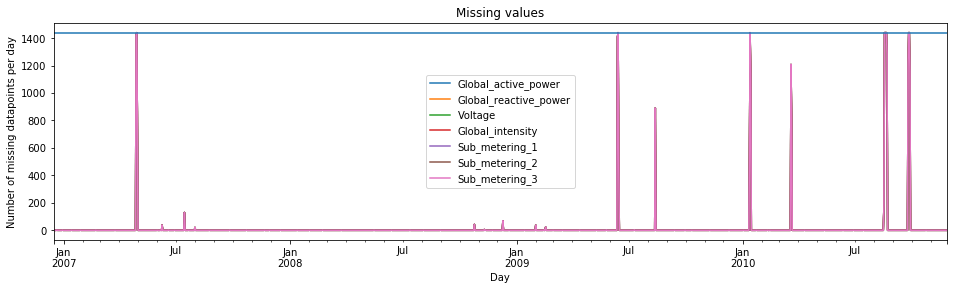

In [15]:
plt.figure(figsize=(16,4))
for c in data.columns:
    missing_data[c].plot()
plt.legend(data.columns)

# there are 1440 minutes in a day
plt.axhline(1440)

plt.ylabel("Number of missing datapoints per day")
plt.xlabel("Day")
plt.title("Missing values")

In [16]:
# check if columns are equal (probably there's a smarter way to do it...)
all(all(data[c].isna() == data['Global_active_power'].isna()) for c in data.columns)

True

It seems we have the same missing data points in each column. There is a few days completely missing, and occassional missing values in some others.

There are many ways to handle missing data, the choice will depend on how we want to use it. For now I'm going to fill it using backfill method (copying the last valid datapoint).

In [17]:
data.fillna(method='bfill', inplace=True)

***

# Some exploratory analysis

In [18]:
data.describe(include='all')

Global_active_power  Global_reactive_power       Voltage  \
count         2.075259e+06           2.075259e+06  2.075259e+06   
mean          1.094391e+00           1.239705e-01  2.408240e+02   
std           1.054990e+00           1.126516e-01  3.251230e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.100000e-01           4.800000e-02  2.389600e+02   
50%           6.200000e-01           1.000000e-01  2.410100e+02   
75%           1.536000e+00           1.960000e-01  2.429000e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.075259e+06    2.075259e+06    2.075259e+06    2.075259e+06  
mean       4.638736e+00    1.107975e+00    1.290500e+00    6.468201e+00  
std        4.434058e+00    6.115943e+00    5.787128e+00    8.455677e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
50%        2.800000e+00    0.000000e+00    0.000000e+00    1.000000e+00  
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01  
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01

### Aggregated by day

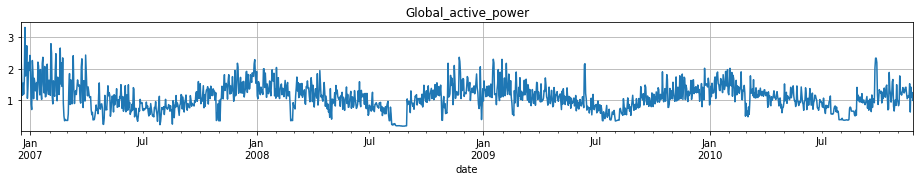

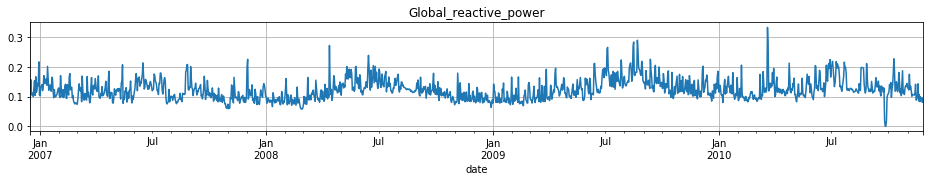

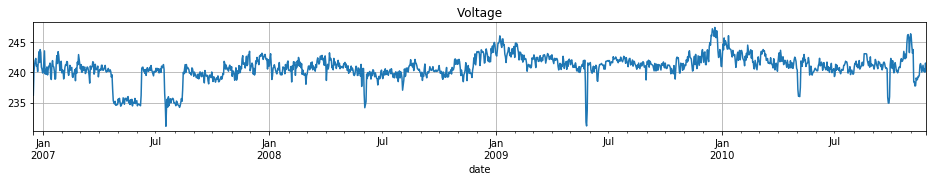

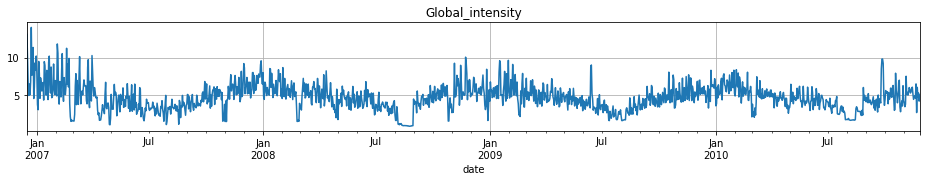

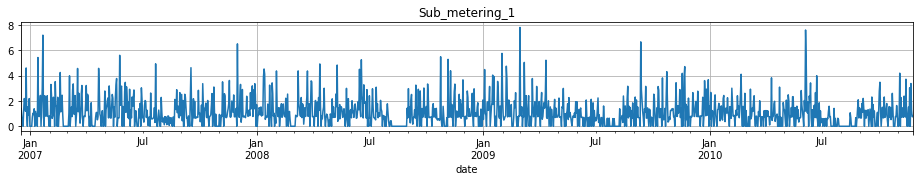

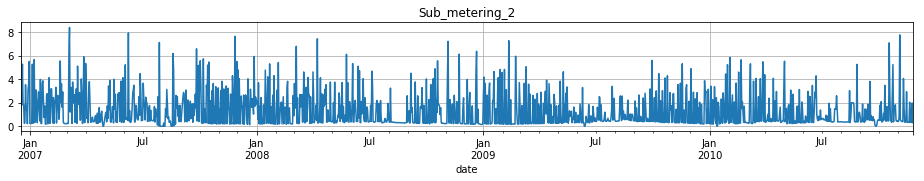

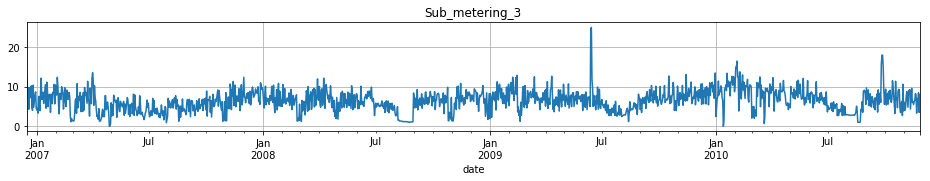

In [19]:
for c in data.columns:
    plt.figure(figsize=(16,2))
    data[c].resample('D').mean().plot()
    plt.grid()
    plt.title(c)

There is some visible seasonality in the data, related to the time of the year. Near-flat consumption that can be spotted in July/August 2008 and 2010 might indicate that the residents left home for vacations.

### Aggregated by week

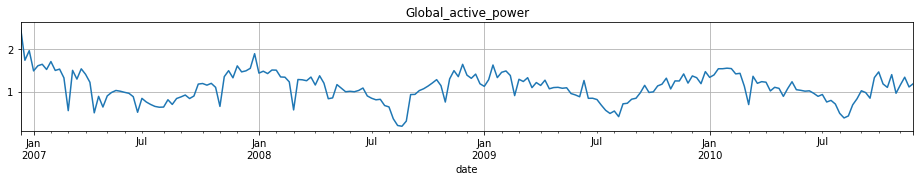

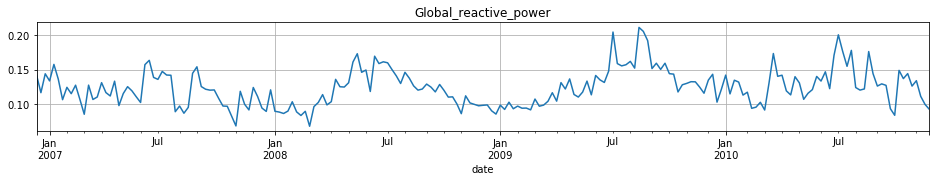

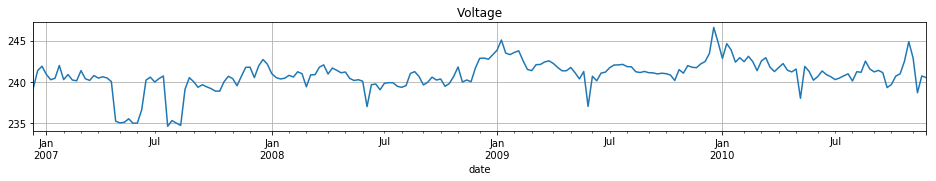

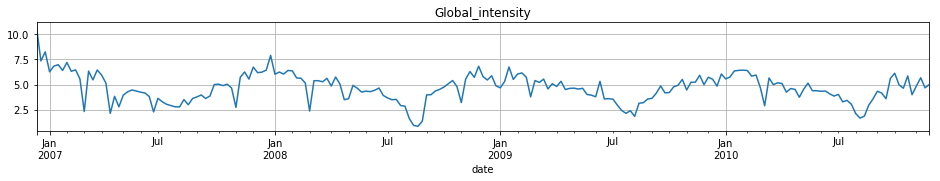

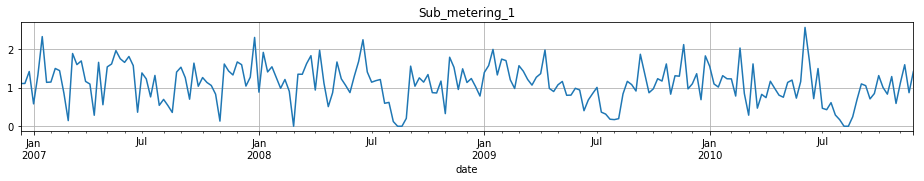

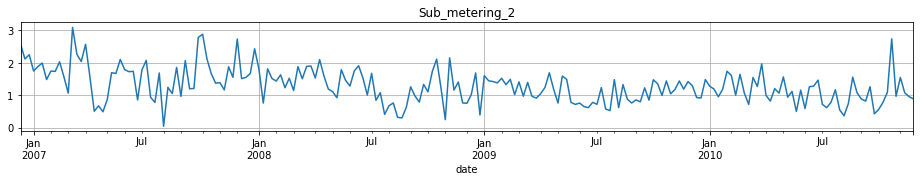

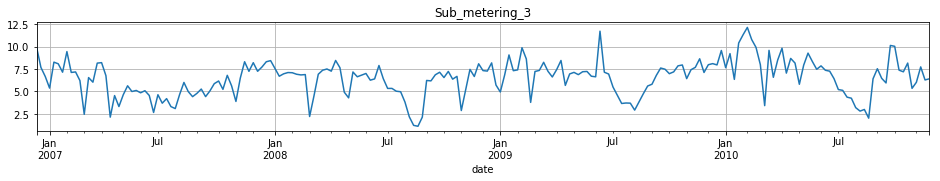

In [20]:
for c in data.columns:
    plt.figure(figsize=(16,2))
    data[c].resample('W').mean().plot()
    plt.grid()
    plt.title(c)

## Signal histograms (daily)

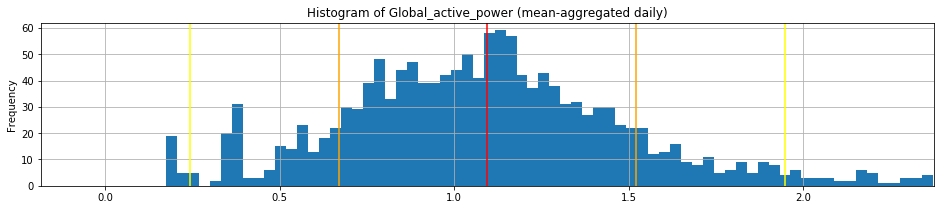

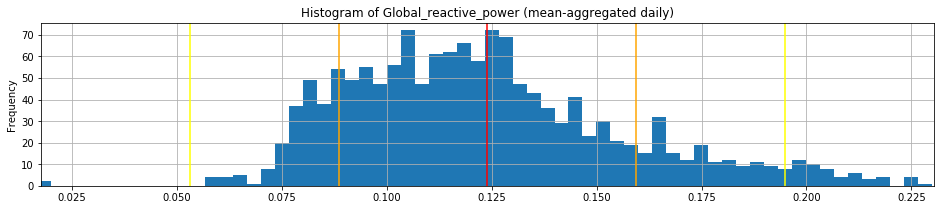

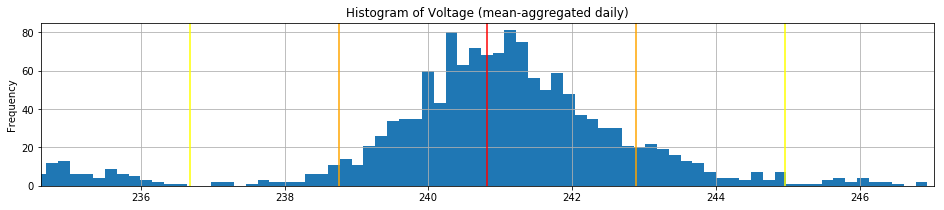

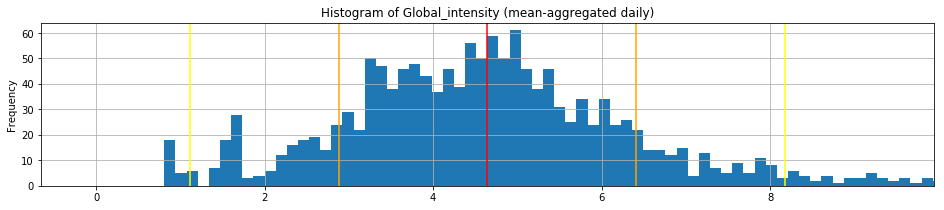

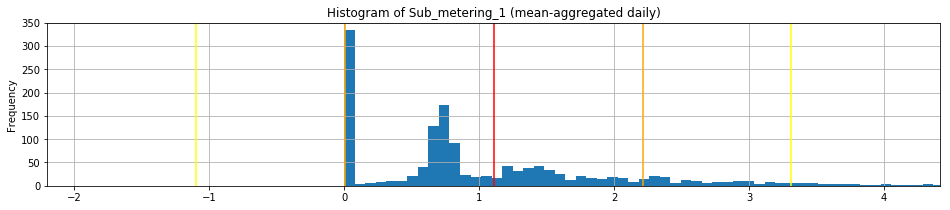

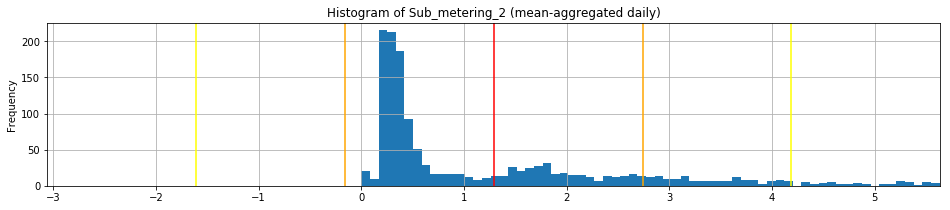

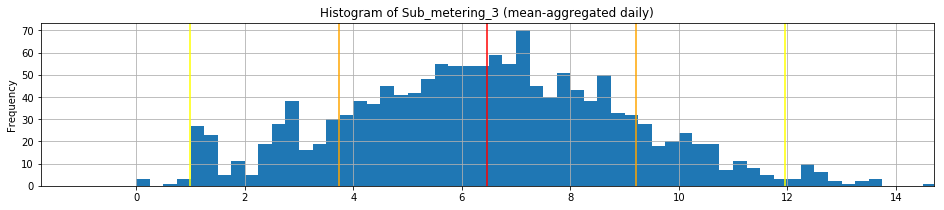

In [48]:
for c in data.columns:
    plt.figure(figsize=(16,3))
    signal = data[c].resample('D').mean() 
    
    plt.xlim([signal.mean() - 3*signal.std(), signal.mean() + 3*signal.std()])
    
#     signal.plot(kind='density')
    signal.plot(kind='hist', bins=100)
    
    # Show mean and standard deviation intervals
    
    plt.axvline(signal.mean(), c='r')
    plt.axvline(signal.mean() - signal.std(), c='orange')
    plt.axvline(signal.mean() + signal.std(), c='orange')
    plt.axvline(signal.mean() - 2*signal.std(), c='yellow')
    plt.axvline(signal.mean() + 2*signal.std(), c='yellow')
    
    plt.grid()
    plt.title("Histogram of {} (mean-aggregated daily)".format(c))

## Signal histograms (hourly)

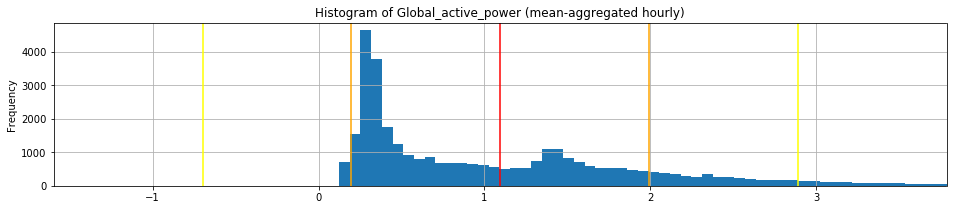

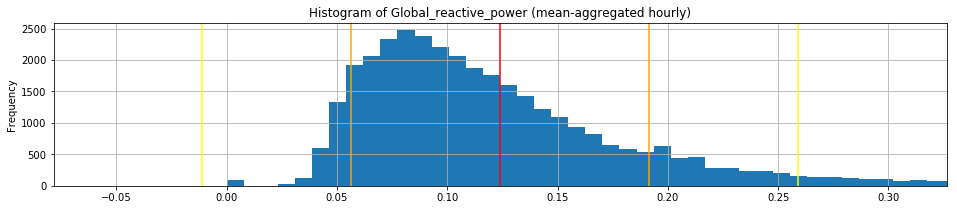

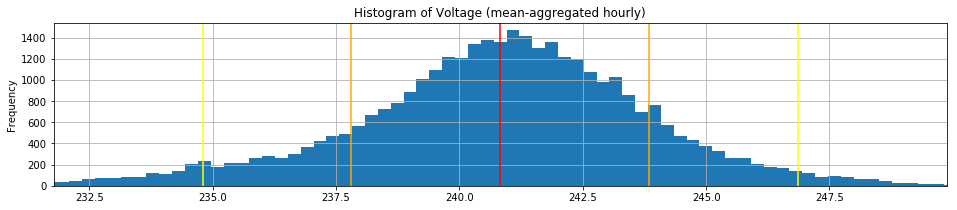

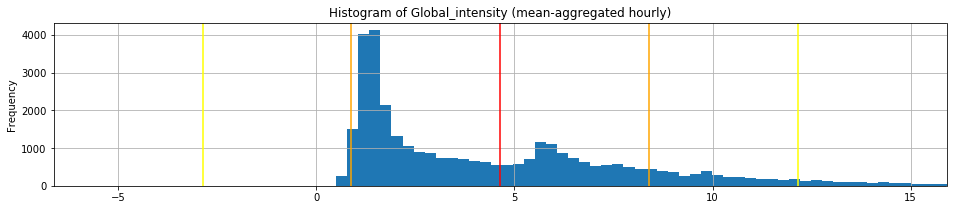

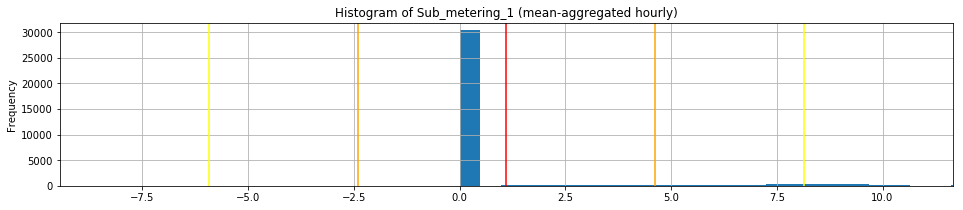

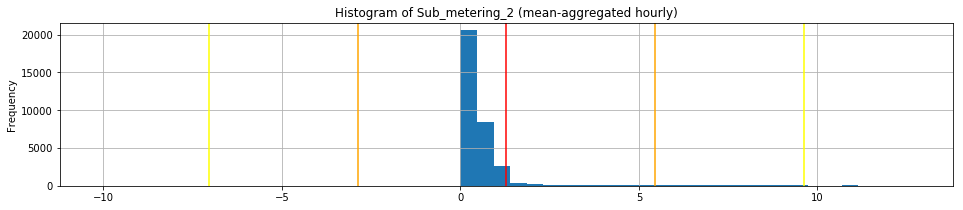

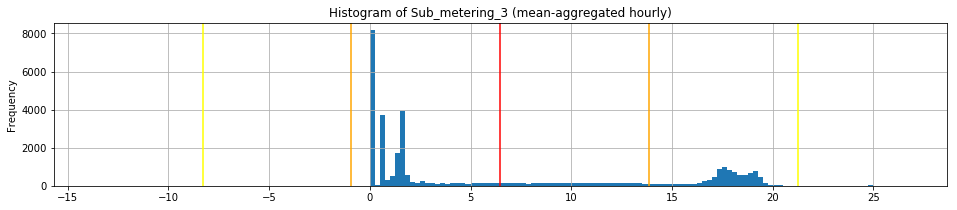

In [47]:
for c in data.columns:
    plt.figure(figsize=(16,3))
    signal = data[c].resample('H').mean() 
    
    plt.xlim([signal.mean() - 3*signal.std(), signal.mean() + 3*signal.std()])
    
    signal.plot(kind='hist', bins=100)
    
    # Show mean and standard deviation intervals
    
    plt.axvline(signal.mean(), c='r')
    plt.axvline(signal.mean() - signal.std(), c='orange')
    plt.axvline(signal.mean() + signal.std(), c='orange')
    plt.axvline(signal.mean() - 2*signal.std(), c='yellow')
    plt.axvline(signal.mean() + 2*signal.std(), c='yellow')
    
    plt.grid()
    plt.title("Histogram of {} (mean-aggregated hourly)".format(c))

### Remarks on the histogram plots

Some of the densities are quite obviously mixtures of two densities. Probably they could be decomposed into two separate patterns. E.g. Sub_metering_3 has a nicely centered daily distribution, but visibly mixed hourly distribution, which suggests two reoccuring "modes" that are changing over 24 hours – perhaps "day" and "night".

Similar (though less obvious) mixture can be seen in the Global Active Power signal. If I understand correctly, Global Active Power is directly influenced by several components, Sub_metering_1-3 being some of them (most important?). Sub_metering_1-2 both have centered hourly densities, so a plausible hypothesis is that the small peak in Global Active Power is a result of Sub_metering_3 alternating between those two states.

On the other hand, Sub_metering_1 sees to alternate between two states over the course of a week.

We can try to verify those observatios by looking at the bar charts.

## Power consumption by day of the week

In [23]:
weekdays = data.groupby(data.index.weekday)
weekdays.mean()

Global_active_power  Global_reactive_power     Voltage  \
date                                                           
0                1.005665               0.115294  240.951858   
1                1.075893               0.117970  240.825824   
2                1.084620               0.120341  240.908153   
3                0.981446               0.114811  240.879896   
4                1.041502               0.118971  240.846467   
5                1.249277               0.143022  240.550470   
6                1.222845               0.137449  240.804114   

      Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
date                                                                    
0             4.259743        0.824592        0.870075        6.292213  
1             4.560144        0.781297        1.336485        6.441997  
2             4.593573        1.048143        1.726935        6.331698  
3             4.156355        0.790281        0.759692        5.964904  
4             4.409254        0.870439        1.002887        6.730874  
5             5.299117        1.687283        1.472337        7.523755  
6             5.195156        1.755687        1.865558        5.995837

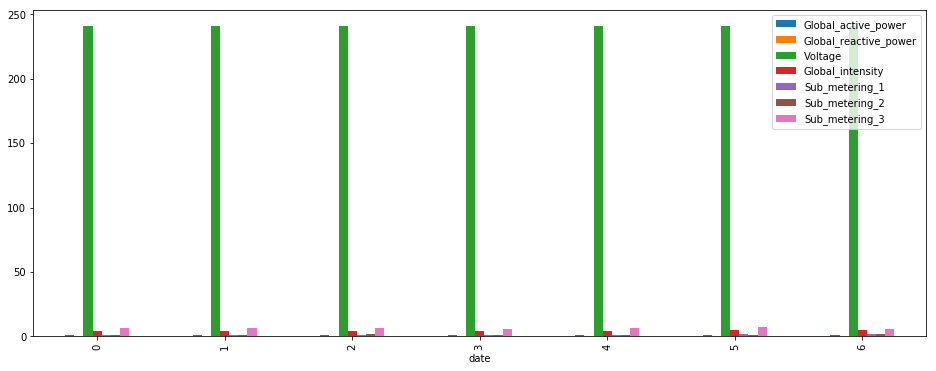

In [24]:
weekdays.mean().plot(kind='bar', figsize=(16,6))


This is not very readable because the scale is very different, let's try logarithmic scale.




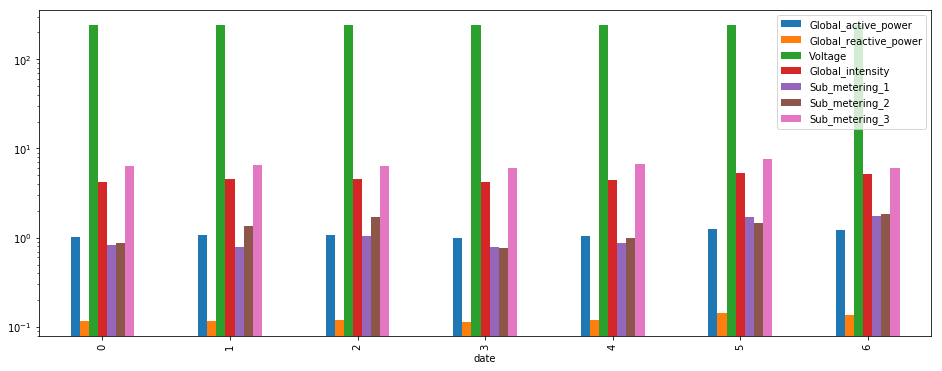

In [25]:
weekdays.mean().plot(kind='bar', logy=True, figsize=(16,6))

Also doesn't tell us much. We could rescale it, but for now let's just plot each variable separately.

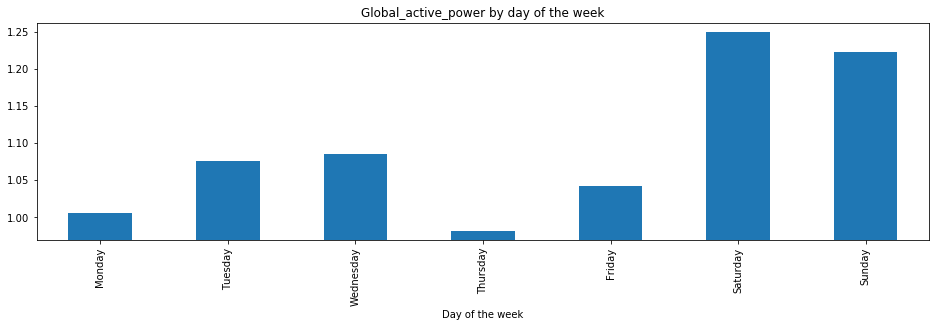

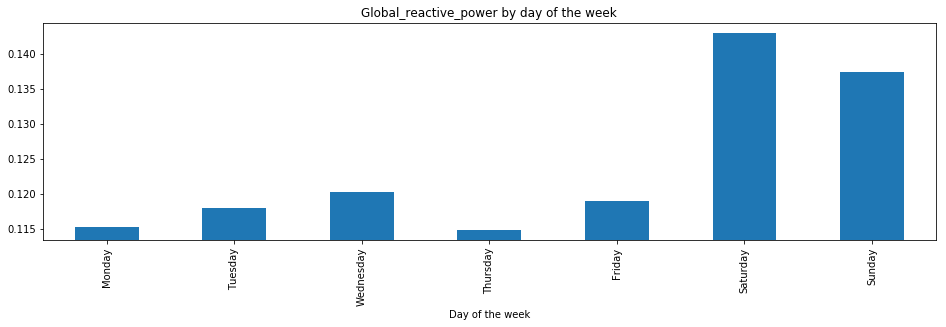

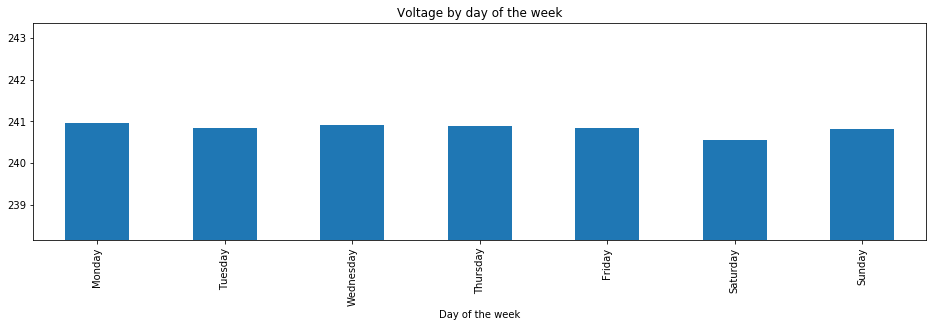

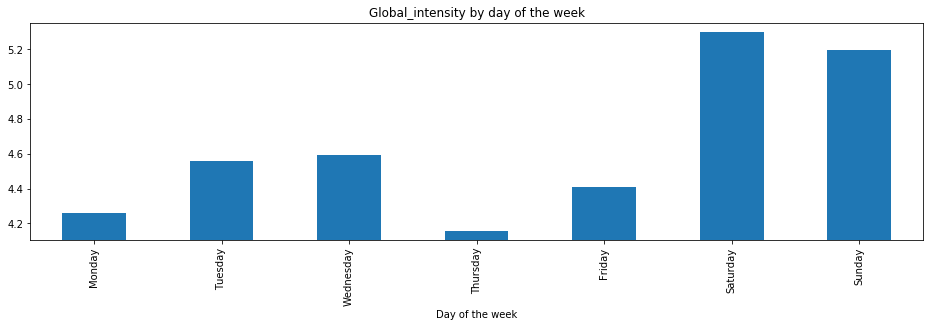

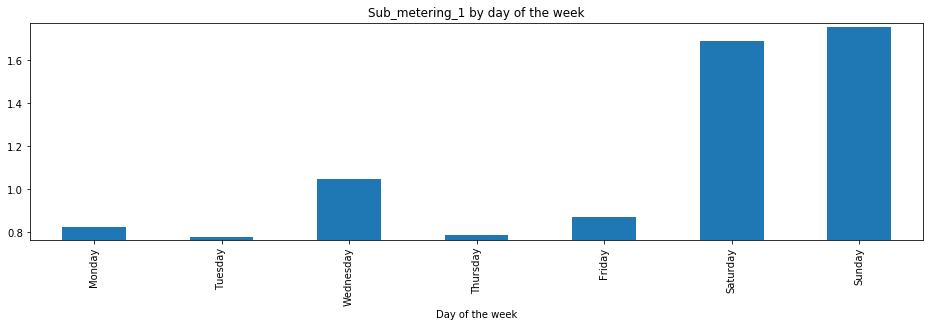

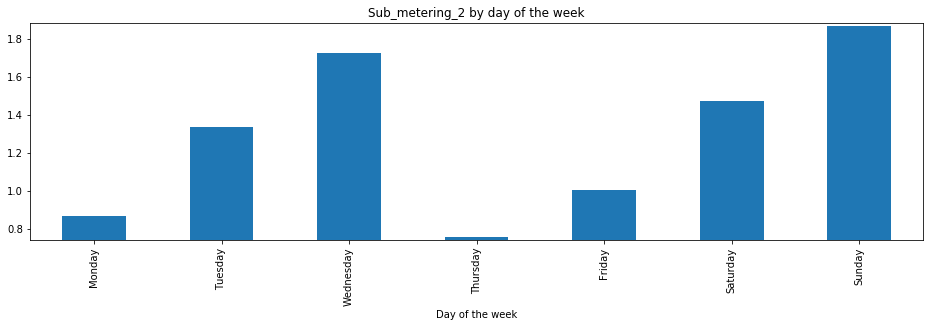

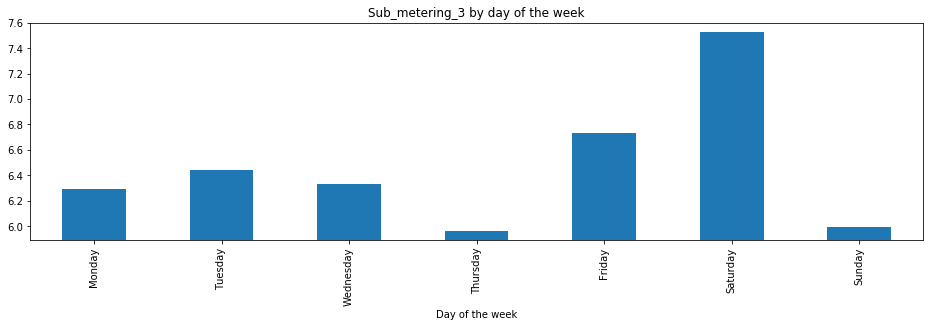

In [26]:
for c in data.columns:
    plt.figure(figsize=(16,4))
    series = weekdays.mean()[c]
    
    plt.grid(True)
    series.plot(kind='bar')
    plt.ylim([series.min()-(series.max()/100), series.max()+(series.max()/100)])
    plt.title("{} by day of the week".format(c))
    plt.xticks(range(7), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    plt.xlabel("Day of the week")
    
    # NB: I crop the plots to highlight relative differences, but such comparison can be potentially misleading
    

Overall consumption is higher on the weekends.

We can confirm now that Sub_metering_1 seems to have two "modes": weekdays, and weekends. ~~Possibly some entertainment device which people use mostly in the weekends (TV?), or perhaps a washing machine?~~ I overlooked that the dataset description actually stated that Sub_metering_1 correponds to the kitchen – makes sense, people cook more at home in the weekends.

## Power consumption by month

In [27]:
months = data.groupby(data.index.month)
months.mean()

Global_active_power  Global_reactive_power     Voltage  \
date                                                           
1                1.469125               0.110748  242.207436   
2                1.300467               0.099696  241.460120   
3                1.230860               0.114287  241.538652   
4                1.029574               0.121815  240.905242   
5                1.029573               0.127905  239.008437   
6                0.933260               0.147535  239.885572   
7                0.700656               0.151920  240.003494   
8                0.574728               0.141702  240.297533   
9                1.017009               0.128853  240.284540   
10               1.137314               0.117079  240.776408   
11               1.291655               0.108795  241.041950   
12               1.490064               0.113709  242.747788   

      Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
date                                                                    
1             6.164633        1.381799        1.521662        7.657756  
2             5.447303        1.131865        1.386560        7.584839  
3             5.174920        1.252571        1.654150        6.849989  
4             4.350197        1.052431        1.147946        6.534219  
5             4.403170        1.234879        1.307790        6.696629  
6             4.024316        1.305035        1.220625        6.534699  
7             3.063485        0.707297        0.992395        4.272558  
8             2.520366        0.485249        0.849171        3.723998  
9             4.340711        1.120856        1.149253        6.709653  
10            4.796415        1.065401        1.485226        6.585551  
11            5.439229        1.291473        1.350491        6.969963  
12            6.226921        1.311815        1.440840        7.813098

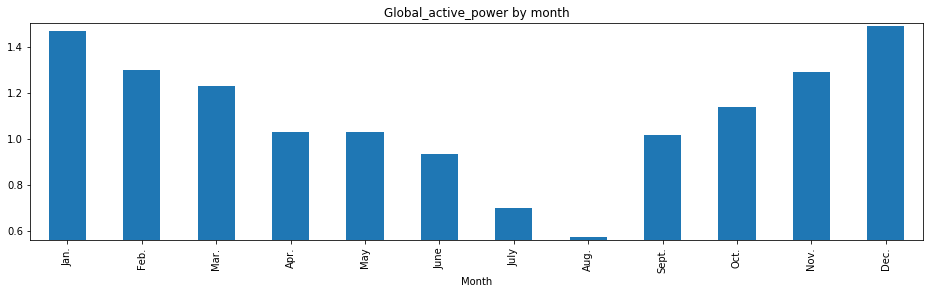

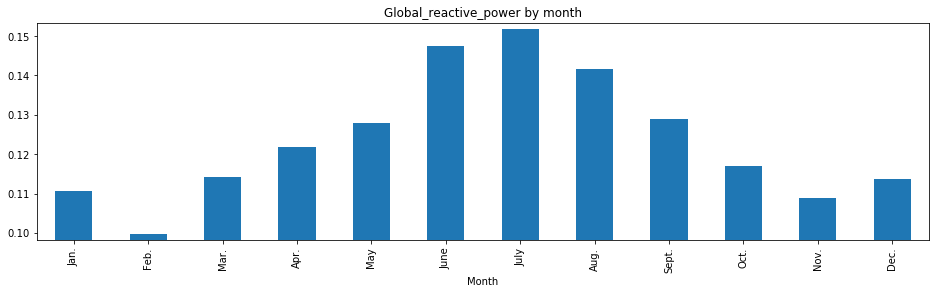

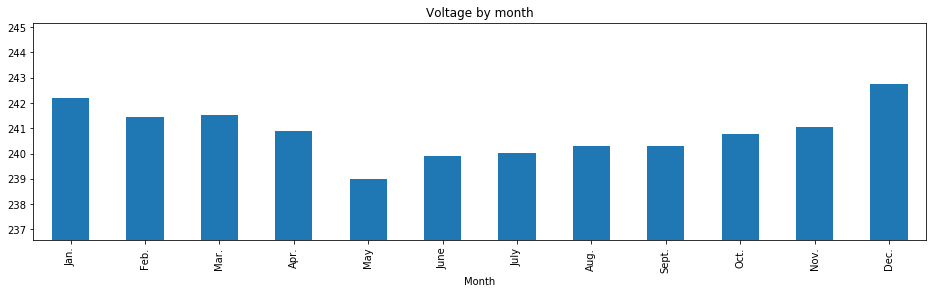

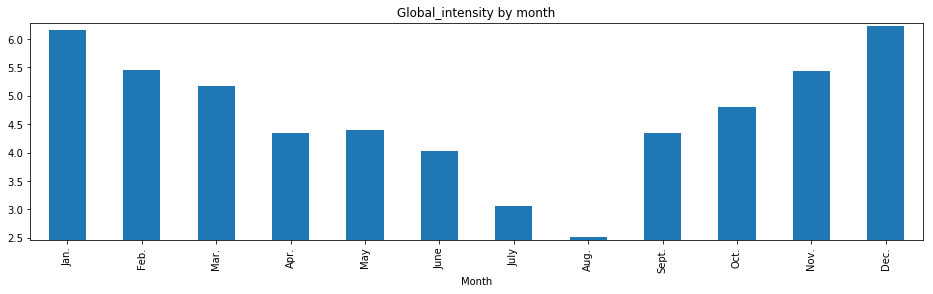

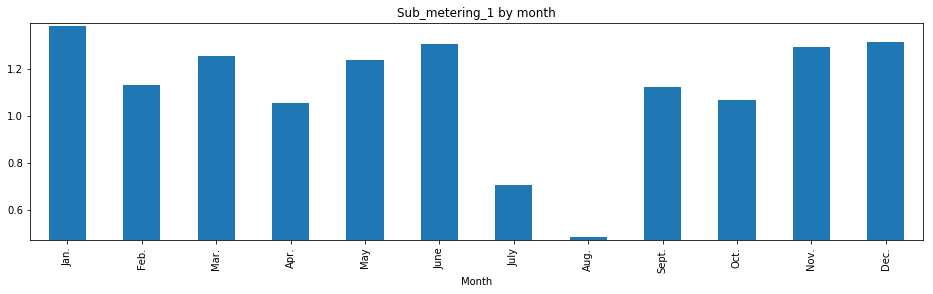

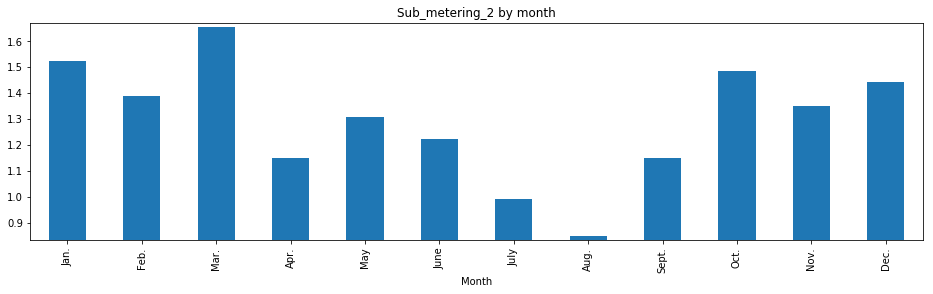

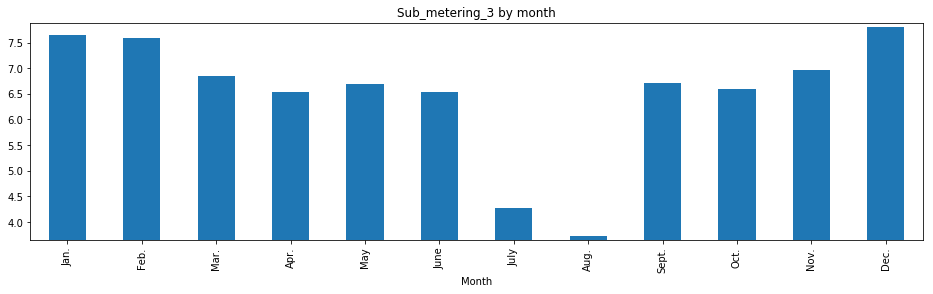

In [28]:
for c in data.columns:
    plt.figure(figsize=(16,4))
    series = months.mean()[c]
    
    plt.grid(True)
    series.plot(kind='bar')
    plt.ylim([series.min()-(series.max()/100), series.max()+(series.max()/100)])
    plt.title("{} by month".format(c))
    plt.xticks(range(12), 
               [
                "Jan.",
                "Feb.",
                "Mar.",
                "Apr.",
                "May",
                "June",
                "July",
                "Aug.",
                "Sept.",
                "Oct.",
                "Nov.",
                "Dec.",
               ]
              )
    plt.xlabel("Month")
    
    # NB: I crop the plots to highlight relative differences, but such comparison can be potentially misleading
    

Overall consumption is much higher in the winter, and lower in the summer. This suggests something like electrical heating, and/or artificial light (longer nights in the winter). It also points to the household being located on the Northern hemisphere, relatively far to the North (which is indeed the case, as we know from the dataset description).

Very low average consumption in July/August might be affected not only by the environmental factors, but also by the residents being off for vacations, as I mentioned previously. That could partly explain why those months have such low values also for Sub_metering_3, which otherwise have quite stable monthly usage, and doesn't seem to be affected too much by the seasons.

## Power consumption by hour of the day

In [29]:
hours = data.groupby(data.index.hour)
hours.mean()

Global_active_power  Global_reactive_power     Voltage  \
date                                                           
0                0.666751               0.115301  242.369520   
1                0.548477               0.105438  241.691924   
2                0.490462               0.105568  242.555117   
3                0.455288               0.103563  242.645397   
4                0.455955               0.100247  242.385926   
5                0.465518               0.097650  242.057554   
6                0.798784               0.103325  241.906268   
7                1.499365               0.110475  239.918131   
8                1.458592               0.111275  239.501666   
9                1.330733               0.106934  239.420802   
10               1.260896               0.117230  239.343856   
11               1.246640               0.128491  239.442667   
12               1.207806               0.142704  240.172080   
13               1.146078               0.133464  240.699872   
14               1.085588               0.129224  241.459596   
15               0.995373               0.133986  241.995158   
16               0.954311               0.132358  241.747307   
17               1.059350               0.132508  240.281843   
18               1.326572               0.142602  239.300062   
19               1.728271               0.182670  238.688806   
20               1.893212               0.158912  239.092135   
21               1.871740               0.133773  239.129805   
22               1.411845               0.127803  240.983075   
23               0.906604               0.119709  242.990536   

      Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
date                                                                    
0             2.837032        0.360294        0.556801        3.017719  
1             2.349743        0.246021        0.400902        2.417176  
2             2.105503        0.144136        0.353632        2.096218  
3             1.960509        0.066956        0.353609        1.765707  
4             1.961899        0.046519        0.337994        1.947085  
5             1.998226        0.035207        0.319639        2.211589  
6             3.399322        0.038885        0.337983        4.283773  
7             6.311393        0.301053        0.504569       10.696253  
8             6.130019        1.353296        1.004580       12.580430  
9             5.592924        1.453424        1.073491       12.466724  
10            5.326415        1.118506        1.531691       11.388526  
11            5.291085        1.478464        1.978129       10.194055  
12            5.136188        1.548207        2.030881        9.068644  
13            4.860155        1.263313        2.407830        8.318899  
14            4.593942        1.455193        2.452857        7.375145  
15            4.216627        1.460537        2.043801        6.189197  
16            4.051356        0.948612        1.837243        5.489174  
17            4.515582        0.702217        1.911950        5.394631  
18            5.650712        1.302369        1.782189        5.779392  
19            7.378599        2.576734        2.096972        6.751803  
20            8.024105        2.747908        1.891436        8.424607  
21            7.897996        2.789771        1.768074        7.615708  
22            5.925480        2.203771        1.163752        5.719362  
23            3.809845        0.947826        0.830407        4.044333

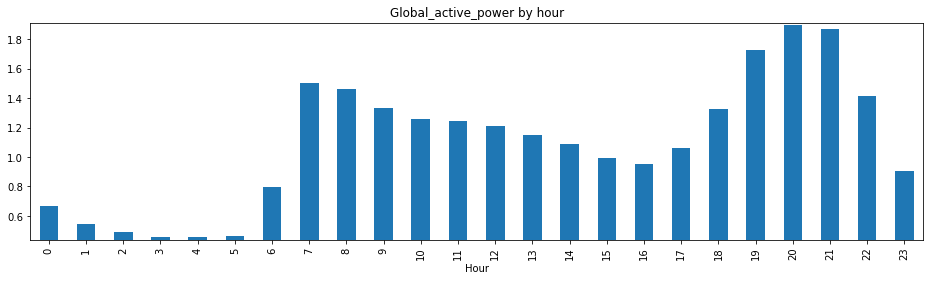

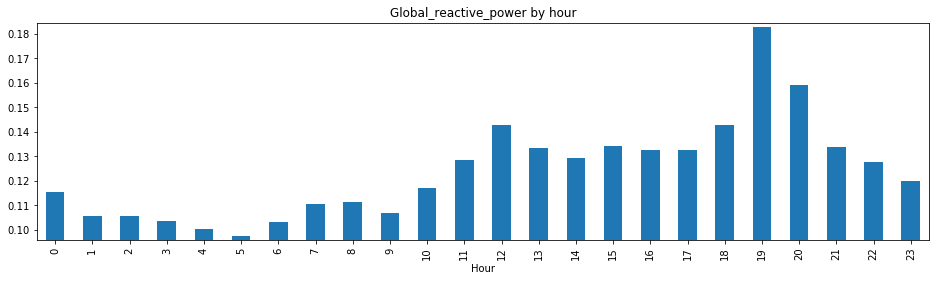

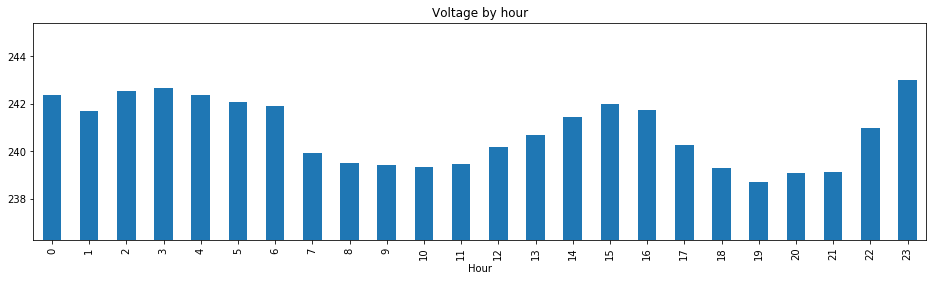

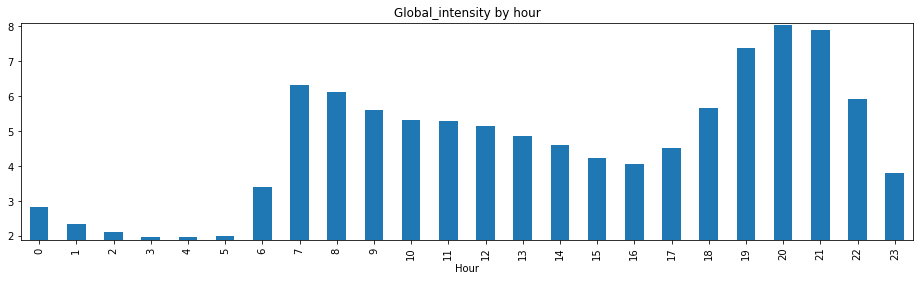

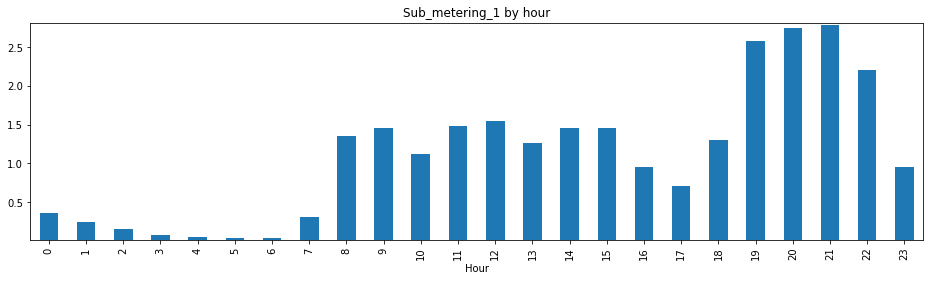

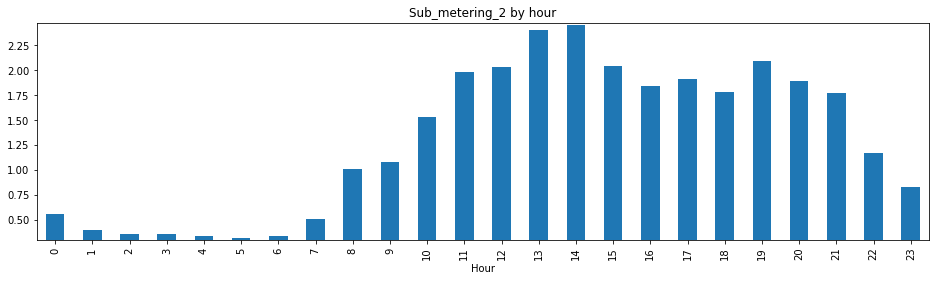

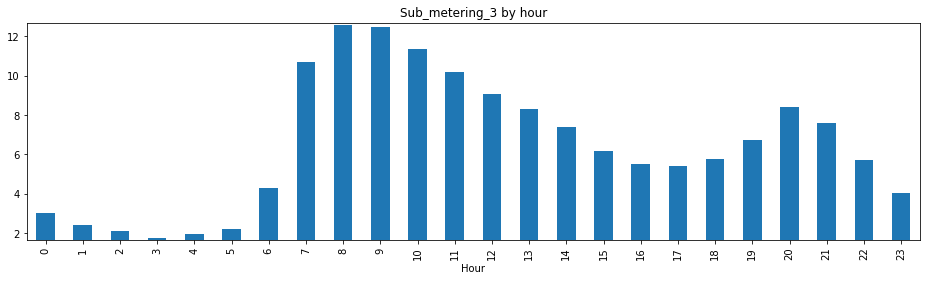

In [30]:
for c in data.columns:
    plt.figure(figsize=(16,4))
    series = hours.mean()[c]
    
    series.plot(kind='bar')
    plt.ylim([series.min()-(series.max()/100), series.max()+(series.max()/100)])
    plt.title("{} by hour".format(c))
    plt.xlabel("Hour")
    
    # NB: I crop the plots to highlight relative differences, but such comparison can be potentially misleading
    

Understandably, power consumption is much higher during the day. Though heating etc. obviously stays on.

***

# Simple predictive modelling

We can already see a lot of patterns here, on the level of time of the year, of the week, and of the day. So let's try to predict one of the variables just based on the timestamps, and the consumption from the previous day. I will try with Global Active Power, hourly average.

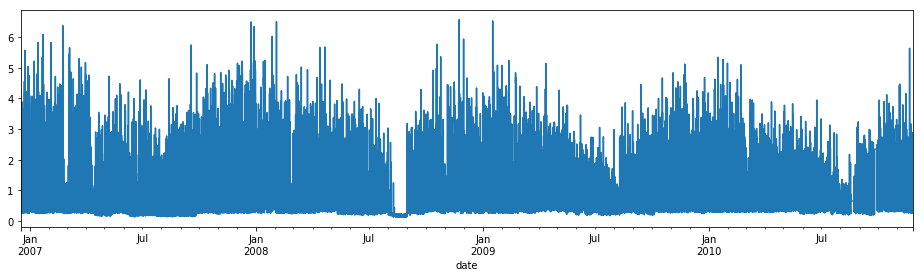

In [31]:
data['Global_active_power'].resample('H').mean().plot(figsize=(16,4))

I will use first 3 years for training, and see if I can predict the usage over 2010.

In [32]:
model_data = pd.DataFrame({"Global_active_power": data['Global_active_power'].resample('H').mean()})

In [33]:
model_data.head()

Global_active_power
date                                    
2006-12-16 17:00:00             4.222889
2006-12-16 18:00:00             3.632200
2006-12-16 19:00:00             3.400233
2006-12-16 20:00:00             3.268567
2006-12-16 21:00:00             3.056467

In [34]:
model_data['hour'] = model_data.index.hour.astype(float)
model_data['weekday'] = model_data.index.weekday.astype(float)
model_data['month'] = model_data.index.month.astype(float)

model_data['GAP_prev'] = model_data['Global_active_power'].shift(24).fillna(0)

In [35]:
model_data.head()

Global_active_power  hour  weekday  month  GAP_prev
date                                                                    
2006-12-16 17:00:00             4.222889  17.0      5.0   12.0       0.0
2006-12-16 18:00:00             3.632200  18.0      5.0   12.0       0.0
2006-12-16 19:00:00             3.400233  19.0      5.0   12.0       0.0
2006-12-16 20:00:00             3.268567  20.0      5.0   12.0       0.0
2006-12-16 21:00:00             3.056467  21.0      5.0   12.0       0.0

In [36]:
features = [
    'hour',
    'weekday',
    'month',
    'GAP_prev'
]

X_train = model_data[:'2009'][features]
y_train = model_data[:'2009'][['Global_active_power']]['Global_active_power']

X_test = model_data['2010'][features]
y_test = model_data['2010'][['Global_active_power']]['Global_active_power']

In [37]:
X_train.dtypes

hour        float64
weekday     float64
month       float64
GAP_prev    float64
dtype: object

In [38]:
y_train.dtypes

dtype('float64')

In [39]:
X_train.shape

(26671, 4)

In [40]:
X_test.shape

(7918, 4)

This is just a simple random forest model, nothing fancy. A linear model will not do, because the relationships are clearly not linear.

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [42]:
model = RandomForestRegressor(n_estimators=50, max_depth=20, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("{:20}{:>10.4f}".format("Prediction MAE", mean_absolute_error(y_test, y_pred)))
print("{:20}{:>10.4f}".format("Average actual value", y_test.mean()))

Prediction MAE          0.4915
Average actual value    1.0746


Text(0.5, 1.0, 'Real vs predicted GAP')

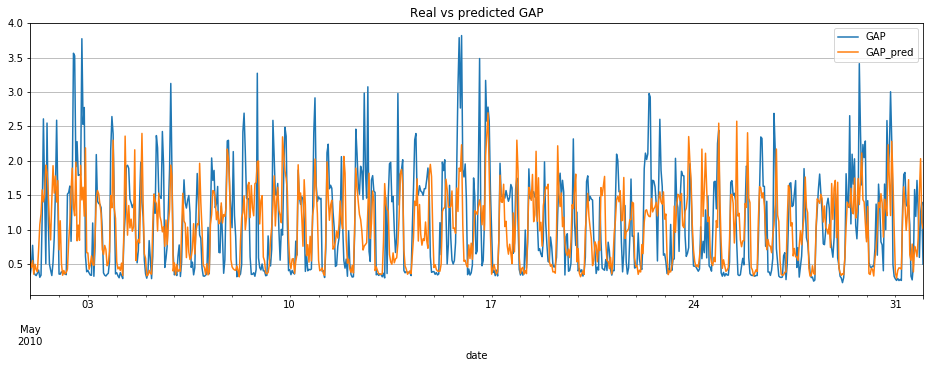

In [43]:
y = pd.DataFrame({"GAP": y_test, "GAP_pred": y_pred})
y['2010-05'].plot(figsize=(16,5))
plt.grid()
plt.title("Real vs predicted GAP")

Text(0.5, 1.0, 'Real vs predicted GAP. Averaged per day')

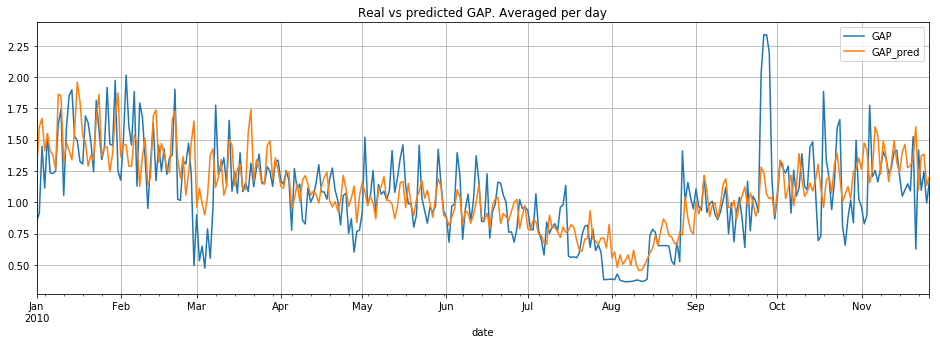

In [44]:
y = pd.DataFrame({"GAP": y_test, "GAP_pred": y_pred}).resample('D').mean()
y.plot(figsize=(16,5))
plt.grid()
plt.title("Real vs predicted GAP. Averaged per day")

Text(0.5, 1.0, 'Real vs predicted GAP. Averaged per week')

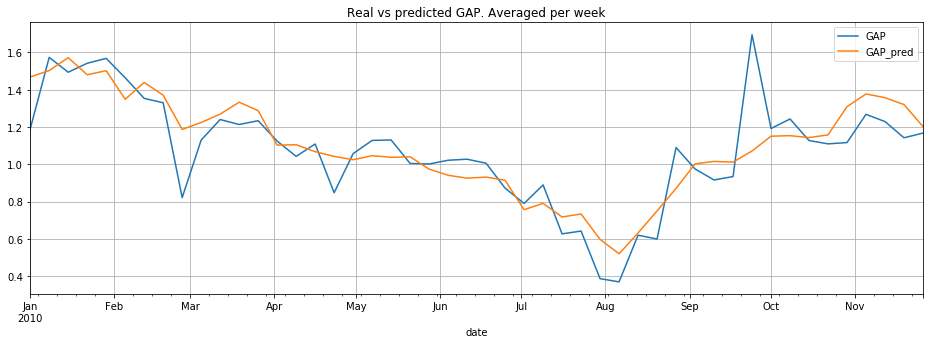

In [45]:
y = pd.DataFrame({"GAP": y_test, "GAP_pred": y_pred}).resample('7D').mean()
y.plot(figsize=(16,5))
plt.grid()
plt.title("Real vs predicted GAP. Averaged per week")

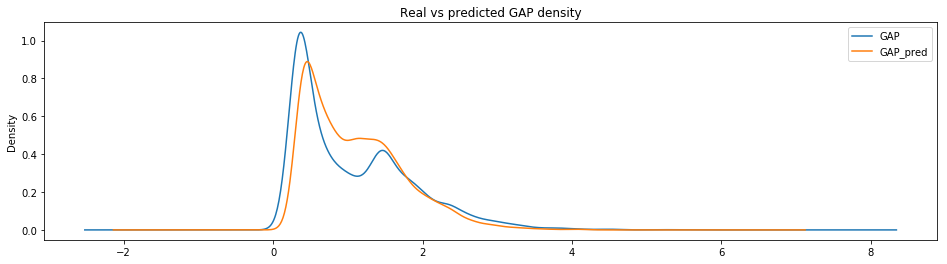

In [46]:
pd.DataFrame({"GAP": y_test, "GAP_pred": y_pred}).plot(
    kind='density', figsize=(16,4), title="Real vs predicted GAP density")

Not very good, but not so bad, either!

A properly done modeling would include more indepth analysis of the trends and seasonality, probably some more clever feature engineering, more capable model, and probably some kind of walk-forward learning/validation.